## INFO https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3951655/

In [ ]:
!pip install datasets
!pip install sentencepiece
!pip install dataprep

     |████████████████████████████████| 163kB 15.7MB/s 
     |████████████████████████████████| 245kB 29.7MB/s 
     |████████████████████████████████| 20.7MB 1.6MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 1.2MB 15.4MB/s 
     |████████████████████████████████| 194kB 18.1MB/s 
     |████████████████████████████████| 368kB 45.0MB/s 
     |████████████████████████████████| 849kB 60.0MB/s 
     |████████████████████████████████| 727kB 32.4MB/s 
     |████████████████████████████████| 1.4MB 52.7MB/s 
     |████████████████████████████████| 9.2MB 45.3MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 1.3MB 49.7MB/s 
     |████████████████████████████████| 102kB 15.6MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 296kB 64.8MB/s 
     |████████████████████████████████

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import gc
import re
import string
import operator
import nltk
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import matplotlib.pyplot as plt
import seaborn as sns

from nltk import ngrams
from nltk import sentiment
import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

from dataprep.eda import plot, plot_correlation, create_report, plot_missing
from pprint import pprint

nltk.download('vader_lexicon')

NumExpr defaulting to 2 threads.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ncbi_disease")

Reusing dataset ncbi_disease (/root/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/ae9eab8e08241fe3cd9860ffc8791dd1c9071c0daf55d7391a38043e876ddd19)


In [ ]:
dframe = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

In [ ]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

In [ ]:
dataset=dataset.drop(['shape'],axis=1)

In [ ]:
!unzip ner.csv.zip

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [ ]:
df_train = pd.DataFrame(dataset['train'])
df_valid = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

In [ ]:
eda_df = pd.concat([df_train,df_valid,df_test], ignore_index=True)
eda_df.shape

(7298, 3)

In [ ]:
df_train

,id,ner_tags,tokens
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[Identification, of, APC2, ,, a, homologue, of..."
1,1,"[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[The, adenomatous, polyposis, coli, (, APC, ),..."
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[Complex, formation, induces, the, rapid, degr..."
3,3,"[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, colon, carcinoma, cells, ,, loss, of, APC..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Here, ,, we, report, the, identification, and..."
...,...,...,...
5428,5428,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Here, ,, we, show, that, retroviral, transfer..."
5429,5429,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, ...","[Mutant, BRCA1, has, no, effect, on, growth, o..."
5430,5430,"[0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Development, of, MCF, -, 7, tumours, in, nude..."
5431,5431,"[0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, ...","[Most, importantly, ,, among, mice, with, esta..."


In [ ]:
pprint(eda_df['ner_tags'].iloc[0])
pprint(eda_df['tokens'].iloc[0])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]
['Identification',
 'of',
 'APC2',
 ',',
 'a',
 'homologue',
 'of',
 'the',
 'adenomatous',
 'polyposis',
 'coli',
 'tumour',
 'suppressor',
 '.']


In [ ]:
# errors
len([1 for ln in eda_df[['ner_tags','tokens']].values 
              if len(ln[0]) != len(ln[1])])

0

In [ ]:
# extract mark_2 and mark_1
mark_2 = []
mark_1 = []
mark_0 = []
for w,p in zip(eda_df['ner_tags'].values, eda_df['tokens'].values):
    for idx, ww in enumerate(w):
       if ww == 2:
         mark_2.append(p[idx])
       if ww == 1:
         mark_1.append(p[idx])
       else:
         mark_0.append(p[idx])

In [ ]:
print(len(mark_2))
print(len(mark_1))
print(len(mark_0))

8299
6892
177660


In [ ]:
len(np.unique(mark_2))

947

In [ ]:
len(np.unique(mark_1))

1154

In [ ]:
len(np.unique(mark_0))

10241

In [ ]:
pd.value_counts(mark_2)

-                873
cancer           411
deficiency       345
syndrome         343
disease          329
                ... 
Pelizaeus          1
fibroblastoma      1
lymphocyte         1
partial            1
spectrum           1
Length: 947, dtype: int64

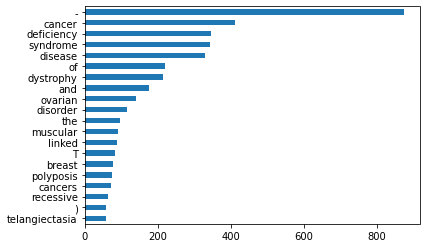

In [ ]:
pd.value_counts(mark_2)[:20][::-1].plot(kind='barh')

### '-' ?????

In [ ]:
# check '-'
l_=[]
for line in eda_df['tokens'].values:
    for idx, ww in enumerate(line):
        if ww == '-':
          strr= f'{line[idx-1]}{line[idx]}{line[idx+1]}'
          l_.append(strr)

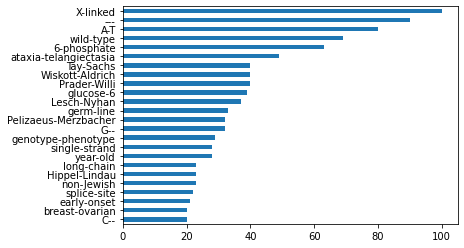

In [ ]:
pd.value_counts(l_)[1:25][::-1].plot(kind='barh')

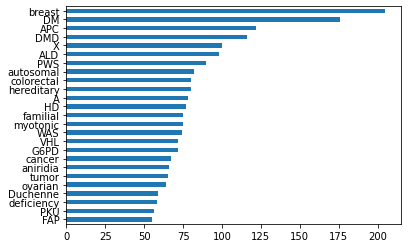

In [ ]:
pd.value_counts(mark_1)[:25][::-1].plot(kind='barh')

In [ ]:
eda_df['sentences'] = eda_df['tokens'].apply(lambda x: str(x)[1:-1])

In [ ]:
import re
def clean_text(text):
    text=' '.join([i for i in text.split(',')])
    text=' '.join([i for i in text.split("'")])
    text=' '.join([i for i in text.split() if i.isalpha()])
    
    return text

In [ ]:
eda_df['content'] = eda_df['sentences'].apply(clean_text)
eda_df

,id,ner_tags,tokens,sentences,content
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]","[Identification, of, APC2, ,, a, homologue, of...","'Identification', 'of', 'APC2', ',', 'a', 'hom...",Identification of a homologue of the adenomato...
1,1,"[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","[The, adenomatous, polyposis, coli, (, APC, ),...","'The', 'adenomatous', 'polyposis', 'coli', '('...",The adenomatous polyposis coli APC tumour supp...
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[Complex, formation, induces, the, rapid, degr...","'Complex', 'formation', 'induces', 'the', 'rap...",Complex formation induces the rapid degradatio...
3,3,"[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, colon, carcinoma, cells, ,, loss, of, APC...","'In', 'colon', 'carcinoma', 'cells', ',', 'los...",In colon carcinoma cells loss of APC leads to ...
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[Here, ,, we, report, the, identification, and...","'Here', ',', 'we', 'report', 'the', 'identific...",Here we report the identification and genomic ...
...,...,...,...,...,...
7293,936,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[In, an, attempt, to, resolve, this, issue, ,,...","'In', 'an', 'attempt', 'to', 'resolve', 'this'...",In an attempt to resolve this issue we have co...
7294,937,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[These, reagents, detect, a, 220, -, kD, prote...","'These', 'reagents', 'detect', 'a', '220', '-'...",These reagents detect a kD protein localized i...
7295,938,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Immunohistochemical, staining, of, human, bre...","'Immunohistochemical', 'staining', 'of', 'huma...",Immunohistochemical staining of human breast s...
7296,939,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Conversely, ,, BRCA1, expression, was, reduce...","'Conversely', ',', 'BRCA1', 'expression', 'was...",Conversely expression was reduced or undetecta...


In [ ]:
df_train = pd.DataFrame(eda_df)

In [ ]:
# metafeatures
df_train['word_count'] = df_train['content'].apply(lambda x: len(str(x).split()))
df_train['unique_word_count'] = df_train['content'].apply(lambda x: len(set(str(x).split())))
df_train['stop_word_count'] = df_train['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_train['mean_word_length'] = df_train['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_train['char_count'] = df_train['content'].apply(lambda x: len(str(x)))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
df_train.columns

Index(['id', 'ner_tags', 'tokens', 'sentences', 'content', 'word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count'], dtype='object')

In [ ]:
df_stat = df_train.drop(['id', 'ner_tags', 'tokens', 'sentences','content'], axis=1)


In [ ]:
df_stat.describe()

,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,7298.000000,7298.000000,7298.000000,7298.0,7219.000000,7298.000000,7298.0,7298.0,7298.0
mean,20.279666,18.186626,7.770485,0.0,5.507948,130.191285,0.0,0.0,0.0
std,10.013956,7.961982,4.497751,0.0,0.900552,63.979752,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0
25%,13.000000,13.000000,5.000000,0.0,5.000000,87.000000,0.0,0.0,0.0
50%,19.000000,18.000000,7.000000,0.0,5.454545,124.000000,0.0,0.0,0.0
75%,26.000000,23.000000,10.000000,0.0,6.000000,167.000000,0.0,0.0,0.0
max,83.000000,57.000000,38.000000,0.0,13.000000,522.000000,0.0,0.0,0.0


In [ ]:
senti_analyze = sentiment.vader.SentimentIntensityAnalyzer()
eda_df['sentiment_score'] = pd.DataFrame(eda_df['content'].apply(senti_analyze.polarity_scores).tolist())['compound']
eda_df['sentiment'] = pd.cut(eda_df['sentiment_score'], [-np.inf, -0.35, 0.35, np.inf], labels=['negative', 'neutral', 'positive'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa772761b00>]],
      dtype=object)

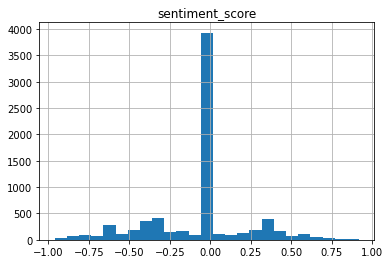

In [ ]:
eda_df[['sentiment_score']].hist(bins=25)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


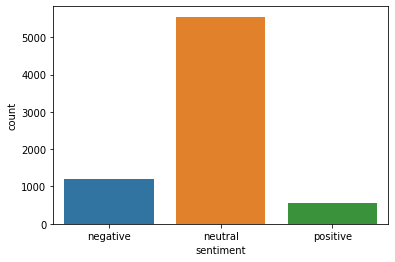

In [ ]:
sns.countplot(eda_df['sentiment'])

In [ ]:
eda_df['lexical_density'] = eda_df['unique_word_count'] / eda_df['word_count']

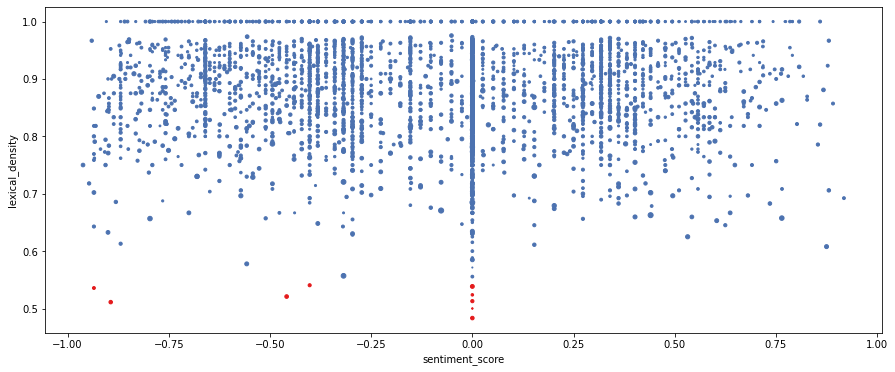

In [ ]:
eda_df.plot.scatter(x='sentiment_score', y='lexical_density', s=eda_df['char_count']/20,
                c=np.where(eda_df['lexical_density'].le(0.55), '#e41a1c', '#4c72b0'),
                figsize=(15, 6))

## bi-lstm ...

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(dataset)

In [ ]:
sentences = getter.sentences

In [ ]:
print(sentences[5])

[('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [ ]:
n_words = len(words); n_words

30174

In [ ]:
tags = list(set(dataset["tag"].values))

In [ ]:
n_tags = len(tags); n_tags

18

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [ ]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [ ]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [ ]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [ ]:
input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


In [ ]:
model = Model(input, out)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

704/704 [==============================] - 676s 953ms/step - loss: 0.2941 - accuracy: 0.9606 - val_loss: 0.0439 - val_accuracy: 0.9885
